In [1]:
# 时间：2021年5月22日14:22:22
# 贡献者：刘
# 前置文件：test8.ipynb
# 文件内容：这是参考文献1的原始代码修改
# 文件描述：功能没有太大变化，依然是数据处理然后逻辑回归
# 实现内容：把代码修修漂亮，这是最终的提交版
# TBD：NaN

# 初始化

In [2]:
# 导入依赖包和一些初始化
import re
import csv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# 画图用的
import seaborn as sns
# 设置浮点数格式
pd.options.display.float_format = '{:.4f}'.format
import datetime as dt
import matplotlib.dates as mdates
# 画图不弹窗，直接内联显示
%matplotlib inline
plt.style.use('default')
# 让代码忽略警告，继续运行
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import resample
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest
from matplotlib import rcParams
from sklearn.utils import resample
# 画图的时候自适应布局
rcParams.update({'figure.autolayout': True})

# 一个数据分析的神仙库
import pandas_profiling as pp

# 读数据

In [3]:
# 加载数据，编码格式是mac_roman
crunchbase = pd.read_csv("cb_objects.csv",index_col=0, encoding='mac_roman')
people = pd.read_csv("cb_people.csv")
ipoInfo=pd.read_csv("cb_ipos.csv")
acquisitionsInfo=pd.read_csv("cb_acquisitions.csv")
degreesInfo=pd.read_csv("cb_degrees.csv")

In [4]:
# 看一眼前五行有啥
crunchbase.head()
# 企业名字，企业主页，企业所处市场类型，融资金额，经营状态（acquired收购，operating运营），所处国家，所处州，所处区域，所处城市，
# 融资轮数，成立日期，成立月份，成立季度，成立年份，首次融资日期，最后融资日期

,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,closed_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
id,,,,,,,,,,,,,,,,,,,,,
c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,17/10/2005,NaN,...,19/5/2008,3.0000,39750000.0000,5/9/2010,18/9/2013,5.0000,17.0000,initial-importer,25/5/2007 06:51:27,13/4/2013 03:29:00
c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,NaN,...,NaN,nan,nan,NaN,NaN,nan,6.0000,initial-importer,31/5/2007 21:11:51,23/5/2008 23:23:14
c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,NaN,...,NaN,nan,nan,1/2/2003,23/9/2011,4.0000,12.0000,initial-importer,6/8/2007 23:52:45,4/11/2013 02:09:48
c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,26/7/2008,NaN,...,NaN,nan,nan,NaN,NaN,nan,nan,NaN,24/8/2008 16:51:57,6/9/2008 14:19:18
c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,26/7/2008,NaN,...,NaN,nan,nan,NaN,NaN,nan,nan,NaN,24/8/2008 17:10:34,6/9/2008 14:19:18


In [5]:
crunchbase.shape

(462651, 39)

In [6]:
# 看一眼创业者的数据有啥
people.head()
# 人的id，人的类型，名，姓，数据库中的链接，照片链接，facebook链接，推特链接，领英链接，所在城市，地区，国家，职称，所属组织（公司的母公司），链接

,id,object_id,first_name,last_name,birthplace,affiliation_name
0,1,p:2,Ben,Elowitz,NaN,Blue Nile
1,2,p:3,Kevin,Flaherty,NaN,Wetpaint
2,3,p:4,Raju,Vegesna,NaN,Zoho
3,4,p:5,Ian,Wenig,NaN,Zoho
4,5,p:6,Kevin,Rose,"Redding, CA",i/o Ventures


In [7]:
ipoInfo.head()

,id,ipo_id,object_id,valuation_amount,valuation_currency_code,raised_amount,raised_currency_code,public_at,stock_symbol,source_url,source_description,created_at,updated_at
0,1,1,c:1654,nan,USD,nan,USD,19/12/1980,NASDAQ:AAPL,NaN,NaN,9/2/2008 05:17:45,12/4/2012 04:02:59
1,2,2,c:1242,nan,USD,nan,NaN,13/3/1986,NASDAQ:MSFT,NaN,NaN,9/2/2008 05:25:18,11/12/2010 12:39:46
2,3,3,c:342,nan,USD,nan,NaN,9/6/1969,NYSE:DIS,NaN,NaN,9/2/2008 05:40:32,23/12/2010 08:58:16
3,4,4,c:59,nan,USD,nan,NaN,25/8/2004,NASDAQ:GOOG,NaN,NaN,10/2/2008 22:51:24,1/8/2011 20:47:08
4,5,5,c:317,100000000000.0000,USD,nan,NaN,1/5/1997,NASDAQ:AMZN,NaN,NaN,10/2/2008 23:28:09,1/8/2011 21:11:22


In [8]:
acquisitionsInfo.head()

,id,acquisition_id,acquiring_object_id,acquired_object_id,term_code,price_amount,price_currency_code,acquired_at,source_url,source_description,created_at,updated_at
0,1,1,c:11,c:10,NaN,20000000.0000,USD,30/5/2007,http://venturebeat.com/2007/05/30/fox-interact...,Fox Interactive confirms purchase of Photobuck...,31/5/2007 22:19:54,21/5/2008 19:23:44
1,2,7,c:59,c:72,cash,60000000.0000,USD,1/7/2007,http://www.techcrunch.com/2007/07/02/deal-is-c...,Deal is Confirmed: Google Acquired GrandCentral,3/7/2007 08:14:50,6/5/2011 21:51:05
2,3,8,c:24,c:132,cash,280000000.0000,USD,1/5/2007,http://www.techcrunch.com/2007/05/30/cbs-acqui...,CBS Acquires Europe’s Last.fm for $280 million,12/7/2007 04:19:24,19/5/2008 04:48:50
3,4,9,c:59,c:155,cash,100000000.0000,USD,1/6/2007,http://techcrunch.com/2007/05/23/100-million-p...,$100 Million Payday For Feedburner ? This Deal...,13/7/2007 09:52:59,5/6/2012 03:22:17
4,5,10,c:212,c:215,cash,25000000.0000,USD,1/7/2007,http://blog.seattlepi.nwsource.com/venture/arc...,seatlepi.com,20/7/2007 05:29:07,25/2/2008 00:23:47


In [9]:
degreesInfo.head()

,id,object_id,degree_type,subject,institution,graduated_at,created_at,updated_at
0,1,p:6117,MBA,NaN,NaN,NaN,19/2/2008 03:17:36,19/2/2008 03:17:36
1,2,p:6136,BA,"English, French","Washington University, St. Louis",1/1/1990,19/2/2008 17:58:31,25/2/2008 00:23:55
2,3,p:6136,MS,Mass Communication,Boston University,1/1/1992,19/2/2008 17:58:31,25/2/2008 00:23:55
3,4,p:6005,MS,Internet Technology,University of Greenwich,1/1/2006,19/2/2008 23:40:40,25/2/2008 00:23:55
4,5,p:5832,BCS,"Computer Science, Psychology",Rice University,NaN,20/2/2008 05:28:09,20/2/2008 05:28:09


# 数据处理

## 洗公司数据

In [10]:
# 重建一个索引
crunchbase.reset_index(inplace=True)

In [11]:
# 挑选出我们可能用到的公司数据
crunchbase=crunchbase.loc[crunchbase["entity_type"]=="Company"]
crunchbase=crunchbase.drop(["entity_type", 
                 "entity_id",
                 "parent_id",
                 "normalized_name",
                 "permalink",
                 "closed_at", 
                 "domain" ,
                 "homepage_url",
                 "twitter_username",
                 "logo_url",
                 "logo_width",
                 "logo_height",
                 "short_description",
                 "description",
                 "overview",
                 "tag_list",
                 "state_code",
                 "region",
                 "first_investment_at",
                 "last_investment_at",
                 "investment_rounds",
                 "invested_companies",
                 "first_funding_at",
                 "last_funding_at", 
                 "first_milestone_at",
                 "last_milestone_at", 
                 "milestones",
                 "created_by",
                 "created_at",
                 "updated_at"], axis=1)

In [12]:
crunchbase.head()

,id,name,category_code,status,founded_at,country_code,city,funding_rounds,funding_total_usd,relationships
0,c:1,Wetpaint,web,operating,17/10/2005,USA,Seattle,3.0000,39750000.0000,17.0000
1,c:10,Flektor,games_video,acquired,NaN,USA,Culver City,nan,nan,6.0000
2,c:100,There,games_video,acquired,NaN,USA,San Mateo,nan,nan,12.0000
3,c:10000,MYWEBBO,network_hosting,operating,26/7/2008,NaN,NaN,nan,nan,nan
4,c:10001,THE Movie Streamer,games_video,operating,26/7/2008,NaN,NaN,nan,nan,nan


In [13]:
crunchbase.shape

(196553, 10)

In [14]:
# 针对代码进行一些列名替换
crunchbase=crunchbase.rename(columns={'category_code':'market'})

In [15]:
# # 把轮数中非数字删掉，空值保留（如果没有非数字类型则会报错）
# crunchbase.drop(crunchbase[~crunchbase.funding_rounds.str.match('^[0-9]+$',na=True)].index,inplace=True)

In [16]:
# # 把关系数中非数字删掉，空值保留
# crunchbase.drop(crunchbase[~crunchbase.relationships.str.match('^[0-9]+$',na=True)].index,inplace=True)

In [17]:
# 把总资金中非数字删掉，空值赋0
crunchbase['funding_total_usd']=crunchbase['funding_total_usd'].fillna('0')
# crunchbase.drop(crunchbase[~crunchbase.funding_total_usd.str.match('^[0-9]+$')].index,inplace=True)
crunchbase['funding_total_usd'] = crunchbase['funding_total_usd'].astype(float)

In [18]:
# 把日期中的其他东西删掉，空值赋0
crunchbase['founded_at']=crunchbase['founded_at'].fillna('0/0/0')
crunchbase.drop(crunchbase[~crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=True)].index,inplace=True)

In [19]:
# 把投资轮数中非数字删掉
# crunchbase.drop(crunchbase[~crunchbase.funding_rounds.str.match('^[0-9]+$',na=True)].index,inplace=True)
# crunchbase['funding_rounds'] = crunchbase['funding_rounds'].astype(float)

In [20]:
# 提取日期中的年份信息，！！请不要修改，套娃套太多了，看不懂的
crunchbase['founded_year']=np.array(crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/').values.tolist())[:,2]
# 删掉0
crunchbase['founded_year'].str.strip('^0$')
crunchbase['founded_year'] = crunchbase['founded_year'].astype(float)
# 帮助理解这块代码的一些参数
# crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)
# crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)]
# crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/')
# crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/').values
# crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/').values.tolist()
# np.array(crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/').values.tolist())
# np.array(crunchbase[crunchbase.founded_at.str.match('\d+\/+\d+\/+\d',na=False)].founded_at.str.split('/').values.tolist())[:,2]

In [21]:
# 把原本企业创建日期删掉
crunchbase=crunchbase.drop("founded_at",axis=1)

In [22]:
crunchbase.shape

(196553, 10)

## 洗创始人信息

In [23]:
people=people[["object_id","affiliation_name"]]
people=people.dropna(axis=0,subset = ["object_id","affiliation_name"])
people=people.drop_duplicates(subset='object_id')

## 洗IPO数据

In [24]:
ipoInfo=ipoInfo[["object_id","public_at"]]
ipoInfo=ipoInfo.dropna(axis=0,subset = ["object_id","public_at"])
ipoInfo=ipoInfo.drop_duplicates(subset='object_id')
ipoInfo['public_at']=np.array(ipoInfo[ipoInfo.public_at.str.match('\d+\/+\d+\/+\d',na=False)].public_at.str.split('/').values.tolist())[:,2]
ipoInfo['public_at'].str.strip('^0$')
ipoInfo['public_at'] = ipoInfo['public_at'].astype(float)

## 洗收购信息

In [25]:
acquisitionsInfo=acquisitionsInfo[["acquired_object_id","acquired_at"]]
acquisitionsInfo=acquisitionsInfo.dropna(axis=0,subset = ["acquired_object_id","acquired_at"])
acquisitionsInfo=acquisitionsInfo.drop_duplicates(subset='acquired_object_id')
acquisitionsInfo['acquired_at']=np.array(acquisitionsInfo[acquisitionsInfo.acquired_at.str.match('\d+\/+\d+\/+\d',na=False)].acquired_at.str.split('/').values.tolist())[:,2]
acquisitionsInfo['acquired_at'].str.strip('^0$')
acquisitionsInfo['acquired_at'] = acquisitionsInfo['acquired_at'].astype(float)

## 洗学位信息

In [26]:
degreesInfo=degreesInfo[["object_id","degree_type"]]
degreesInfo=degreesInfo.dropna(axis=0,subset = ["object_id","degree_type"])
degreesInfo=degreesInfo.drop_duplicates(subset='object_id')
degreesInfo['degree_type'][(degreesInfo['degree_type']!='BS')
                           & (degreesInfo['degree_type']!='MBA')
                           &(degreesInfo['degree_type']!='BA')
                           &(degreesInfo['degree_type']!='MS')
                           &(degreesInfo['degree_type']!='PhD')]='unknown'

In [27]:
degreesInfo.head()

,object_id,degree_type
0,p:6117,MBA
1,p:6136,BA
3,p:6005,MS
4,p:5832,unknown
5,p:1017,BS


In [28]:
degreesInfoOnehot = pd.get_dummies(degreesInfo['degree_type'])
degreesInfo=pd.merge(degreesInfo,degreesInfoOnehot,left_index= True ,right_index= True)
degreesInfo=degreesInfo.drop('degree_type',axis=1)

In [29]:
degreesInfo.head()

,object_id,BA,BS,MBA,MS,PhD,unknown
0,p:6117,0,0,1,0,0,0
1,p:6136,1,0,0,0,0,0
3,p:6005,0,0,0,1,0,0
4,p:5832,0,0,0,0,0,1
5,p:1017,0,1,0,0,0,0


## 融合后数据处理

In [30]:
# 先把创始人信息和学位融合
master = pd.merge(people, degreesInfo, how='left',left_on=['object_id'], right_on=['object_id'])
master['BA']=master['BA'].fillna(0)
master['BS']=master['BS'].fillna(0)
master['MBA']=master['MBA'].fillna(0)
master['MS']=master['MS'].fillna(0)
master['PhD']=master['PhD'].fillna(0)
master['unknown']=master['unknown'].fillna(1)

In [31]:
master.head()

,object_id,affiliation_name,BA,BS,MBA,MS,PhD,unknown
0,p:2,Blue Nile,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
1,p:3,Wetpaint,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,p:4,Zoho,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,p:5,Zoho,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,p:6,i/o Ventures,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [32]:
# 融合创业者和初创企业的关系为一个数据
master=pd.merge(master, crunchbase, how='left',left_on=['affiliation_name'], right_on=['name'])
master=master.drop('affiliation_name',axis=1)

In [33]:
master.head()

,object_id,BA,BS,MBA,MS,PhD,unknown,id,name,market,status,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year
0,p:2,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,c:4993,Blue Nile,web,operating,USA,Seattle,2.0000,49000000.0000,19.0000,1999.0000
1,p:3,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,c:1,Wetpaint,web,operating,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000
2,p:4,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,c:3,Zoho,software,operating,USA,Pleasanton,nan,0.0000,18.0000,2005.0000
3,p:5,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,c:3,Zoho,software,operating,USA,Pleasanton,nan,0.0000,18.0000,2005.0000
4,p:6,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,c:16441,i/o Ventures,other,operating,USA,San Francisco,nan,0.0000,23.0000,2010.0000


In [34]:
# 统计创业者的任职公司的分布，看哪家公司出来几个人
peopleSum=master.groupby(['name']).agg({'object_id': "nunique", 'BA':'sum',  'BS':'sum', 'MBA':'sum', 'MS':'sum', 'PhD':'sum','unknown':'sum'})
peopleSum=peopleSum.rename(columns = {"object_id": "numEntrepreneurs"})
# 重建一个索引
peopleSum = peopleSum.reset_index()

In [35]:
peopleSum.head()

,name,numEntrepreneurs,BA,BS,MBA,MS,PhD,unknown
0,! Haz Life,1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,#waywire,1,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,(In)Touch Network,1,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
3,(fluff)Friends,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,*faircompanies,2,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000


In [36]:
master=pd.merge(crunchbase, peopleSum, how='right',left_on=['name'], right_on=['name'])

In [37]:
master.head()

,id,name,market,status,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year,numEntrepreneurs,BA,BS,MBA,MS,PhD,unknown
0,c:1,Wetpaint,web,operating,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000,2,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000
1,c:10,Flektor,games_video,acquired,USA,Culver City,nan,0.0000,6.0000,0.0000,2,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,c:100,There,games_video,acquired,USA,San Mateo,nan,0.0000,12.0000,0.0000,4,0.0000,0.0000,0.0000,0.0000,1.0000,3.0000
3,c:10002,Synergie Media,advertising,operating,MAR,Agadir,nan,0.0000,2.0000,2007.0000,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,c:1001,FriendFeed,web,acquired,USA,Mountain View,1.0000,5000000.0000,14.0000,2007.0000,2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000


In [38]:
# 再把上市时间融合进去
master=pd.merge(master, ipoInfo,how='left',left_on=['id'],right_on=['object_id']).drop("object_id",axis=1)

In [39]:
# 再把被收购时间融合进去
master=pd.merge(master, acquisitionsInfo,how='left',left_on=['id'],right_on=['acquired_object_id']).drop("acquired_object_id",axis=1)

In [40]:
# 检查一下数据集大小，确保融合是正确的
print(crunchbase.shape)
print(people.shape)
print(ipoInfo.shape)
print(acquisitionsInfo.shape)
print(master.shape)

(196553, 10)
(226689, 2)
(659, 2)
(9383, 2)
(22898, 19)


In [41]:
master.head()

,id,name,market,status,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year,numEntrepreneurs,BA,BS,MBA,MS,PhD,unknown,public_at,acquired_at
0,c:1,Wetpaint,web,operating,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000,2,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,nan,nan
1,c:10,Flektor,games_video,acquired,USA,Culver City,nan,0.0000,6.0000,0.0000,2,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,nan,2007.0000
2,c:100,There,games_video,acquired,USA,San Mateo,nan,0.0000,12.0000,0.0000,4,0.0000,0.0000,0.0000,0.0000,1.0000,3.0000,nan,2005.0000
3,c:10002,Synergie Media,advertising,operating,MAR,Agadir,nan,0.0000,2.0000,2007.0000,1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,nan,nan
4,c:1001,FriendFeed,web,acquired,USA,Mountain View,1.0000,5000000.0000,14.0000,2007.0000,2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,nan,2009.0000


In [42]:
# 企业成功的定义！对企业的运营状况onehot特征化

master['success']=0
master['success'][(master['status'] == 'ipo') & (master['public_at']-master['founded_year']<=5)]=1
master['success'][(master['status'] == 'acquired') & (master['acquired_at']-master['founded_year']<=5)]=1

In [43]:
master.success.sum()

783

## 只关注2000年金融危机后的数据

In [44]:
# 根据2000年金融危机，所以我们定义2000年以后成立的企业是初创公司，第一次数据锐减，从196553~76432
master['startup'] = 0
master['startup'][(master['founded_year'] > 2000)] = 1
startups = master[(master['startup'] == 1)]

In [45]:
startups.shape

(12175, 21)

In [46]:
startups.head()

,id,name,market,status,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year,...,BA,BS,MBA,MS,PhD,unknown,public_at,acquired_at,success,startup
0,c:1,Wetpaint,web,operating,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,nan,nan,0,1
3,c:10002,Synergie Media,advertising,operating,MAR,Agadir,nan,0.0000,2.0000,2007.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,nan,nan,0,1
4,c:1001,FriendFeed,web,acquired,USA,Mountain View,1.0000,5000000.0000,14.0000,2007.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,nan,2009.0000,1,1
5,c:10011,PoetryVisualized.com,games_video,operating,USA,Julian,nan,0.0000,3.0000,2008.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,nan,nan,0,1
6,c:10014,Mobclix,mobile,acquired,USA,Palo Alto,1.0000,0.0000,9.0000,2008.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,4.0000,nan,2010.0000,1,1


In [47]:
startups.success.sum()

729

In [48]:
# 我们的数据是到2013年截止的，计算运营时间
startups['age'] = 2013 - startups['founded_year']

In [49]:
# 保存数据
startups.to_csv('startups.csv')

# 数据分析

In [50]:
# 对数据类型是数字的特征（包括刚特征化的企业运营状况）计算相关系数
master.corr()

,funding_rounds,funding_total_usd,relationships,founded_year,numEntrepreneurs,BA,BS,MBA,MS,PhD,unknown,public_at,acquired_at,success,startup
funding_rounds,1.0000,0.3831,0.1652,0.1205,0.1351,0.1135,0.1072,0.0987,0.0580,0.0351,0.1294,0.3613,0.1356,-0.0135,0.0926
funding_total_usd,0.3831,1.0000,0.1793,0.0910,0.2155,0.1614,0.1458,0.1664,0.1017,0.0817,0.1863,0.2118,0.0346,0.0285,0.0544
relationships,0.1652,0.1793,1.0000,0.0961,0.7342,0.4614,0.6348,0.5639,0.4024,0.3367,0.5787,-0.3680,-0.1706,0.0811,-0.0003
founded_year,0.1205,0.0910,0.0961,1.0000,0.0971,0.0554,0.0590,0.0500,0.0312,0.0187,0.1044,0.1954,0.1610,0.1512,0.8579
numEntrepreneurs,0.1351,0.2155,0.7342,0.0971,1.0000,0.6124,0.7703,0.6383,0.5133,0.3763,0.8892,-0.1012,-0.0677,0.0821,0.0449
BA,0.1135,0.1614,0.4614,0.0554,0.6124,1.0000,0.4389,0.3521,0.2503,0.1899,0.3934,-0.0805,-0.0483,0.0694,0.0195
BS,0.1072,0.1458,0.6348,0.0590,0.7703,0.4389,1.0000,0.4745,0.3874,0.2959,0.5039,-0.1264,-0.0412,0.0608,0.0198
MBA,0.0987,0.1664,0.5639,0.0500,0.6383,0.3521,0.4745,1.0000,0.3245,0.2475,0.4306,-0.1126,-0.0492,0.0562,-0.0034
MS,0.0580,0.1017,0.4024,0.0312,0.5133,0.2503,0.3874,0.3245,1.0000,0.1763,0.3242,-0.1222,-0.0342,0.0199,0.0014
PhD,0.0351,0.0817,0.3367,0.0187,0.3763,0.1899,0.2959,0.2475,0.1763,1.0000,0.2509,-0.1238,-0.0378,0.0265,-0.0041


In [51]:
# 统计一下刚才这些数字特征
master.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
funding_rounds,6369.0000,2.0722,1.5070,1.0000,1.0000,2.0000,3.0000,15.0000
funding_total_usd,22898.0000,4985194.9232,37493214.1605,0.0000,0.0000,0.0000,0.0000,2425700000.0000
relationships,22816.0000,5.4897,20.3314,1.0000,1.0000,2.0000,5.0000,1189.0000
founded_year,22898.0000,1219.8994,979.4770,0.0000,0.0000,2003.0000,2009.0000,2013.0000
numEntrepreneurs,22898.0000,1.5105,2.7657,1.0000,1.0000,1.0000,1.0000,244.0000
BA,22898.0000,0.1331,0.4875,0.0000,0.0000,0.0000,0.0000,23.0000
BS,22898.0000,0.2097,0.7546,0.0000,0.0000,0.0000,0.0000,55.0000
MBA,22898.0000,0.0924,0.4133,0.0000,0.0000,0.0000,0.0000,24.0000
MS,22898.0000,0.0781,0.3357,0.0000,0.0000,0.0000,0.0000,21.0000
PhD,22898.0000,0.0229,0.1727,0.0000,0.0000,0.0000,0.0000,7.0000


In [52]:
# 统计一下初创公司的数值信息
startups.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
funding_rounds,5319.0000,2.1342,1.5288,1.0000,1.0000,2.0000,3.0000,15.0000
funding_total_usd,12175.0000,6898876.2523,43671569.5409,0.0000,0.0000,0.0000,1250000.0000,2425700000.0000
relationships,12150.0000,5.4834,8.5932,1.0000,2.0000,3.0000,6.0000,473.0000
founded_year,12175.0000,2008.4537,2.9159,2001.0000,2007.0000,2009.0000,2011.0000,2013.0000
numEntrepreneurs,12175.0000,1.6269,1.7883,1.0000,1.0000,1.0000,2.0000,63.0000
BA,12175.0000,0.1420,0.4728,0.0000,0.0000,0.0000,0.0000,22.0000
BS,12175.0000,0.2237,0.5328,0.0000,0.0000,0.0000,0.0000,14.0000
MBA,12175.0000,0.0911,0.3364,0.0000,0.0000,0.0000,0.0000,6.0000
MS,12175.0000,0.0785,0.2966,0.0000,0.0000,0.0000,0.0000,5.0000
PhD,12175.0000,0.0223,0.1588,0.0000,0.0000,0.0000,0.0000,3.0000


# 画初创企业的图

##  画出初创企业的前10个分布国家

In [53]:
# 数据处理
countries_startups = startups.groupby(['country_code']).agg({'name': 'nunique',
                                                    'success': "sum"}).sort_values(by="name",ascending=False)

countries_startups['fail'] = countries_startups['name'] - countries_startups['success']
countries_startups['success_per'] = countries_startups['success'] / countries_startups['name']

countries_startups=countries_startups.head(10)
countries_startups.reset_index(inplace=True)
countries_startups

,country_code,name,success,fail,success_per
0,USA,6559,540,6019,0.0823
1,GBR,708,32,676,0.0452
2,CAN,377,29,348,0.0769
3,IND,267,3,264,0.0112
4,DEU,233,9,224,0.0386
5,FRA,202,6,196,0.0297
6,ISR,162,10,152,0.0617
7,ESP,149,4,145,0.0268
8,AUS,136,1,135,0.0074
9,NLD,105,3,102,0.0286


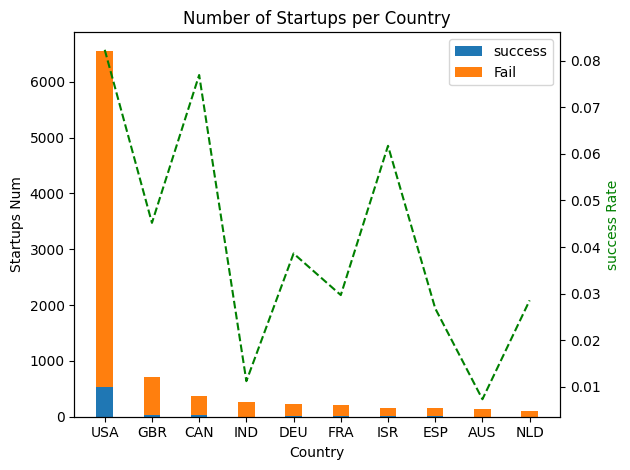

In [54]:
# 画图
labels = countries_startups.country_code
success_means = countries_startups.success
fail_means = countries_startups.fail
y2=countries_startups.success_per


width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.bar(labels,success_means, width, label='success')
ax.bar(labels, fail_means, width, bottom=success_means,
       label='Fail')
ax.set_xlabel('Country')
ax.set_ylabel('Startups Num')


ax2.set_ylabel('success Rate', color='g')
ax2.plot(labels, y2, 'g--')
ax.set_title('Number of Startups per Country')
ax.legend()
# fig.show()
fig.savefig('Number_of_Startups_per_Country.png', dpi=1000, transparent=True)

## 画出初创企业的前十个分布城市

In [55]:
# 数据处理
cities_startups = startups.groupby(['city']).agg({'name': 'nunique',
                                                    'success': "sum"}).sort_values(by="name",ascending=False)

cities_startups['fail'] = cities_startups['name'] - cities_startups['success']
cities_startups['success_per'] = cities_startups['success'] / cities_startups['name']

cities_startups=cities_startups.head(10)
cities_startups.reset_index(inplace=True)
cities_startups

,city,name,success,fail,success_per
0,San Francisco,1027,138,889,0.1344
1,New York,741,61,680,0.0823
2,London,417,17,400,0.0408
3,Palo Alto,202,26,176,0.1287
4,Los Angeles,190,15,175,0.0789
5,Seattle,175,23,152,0.1314
6,Mountain View,148,25,123,0.1689
7,Chicago,147,10,137,0.0680
8,Austin,137,9,128,0.0657
9,Paris,120,5,115,0.0417


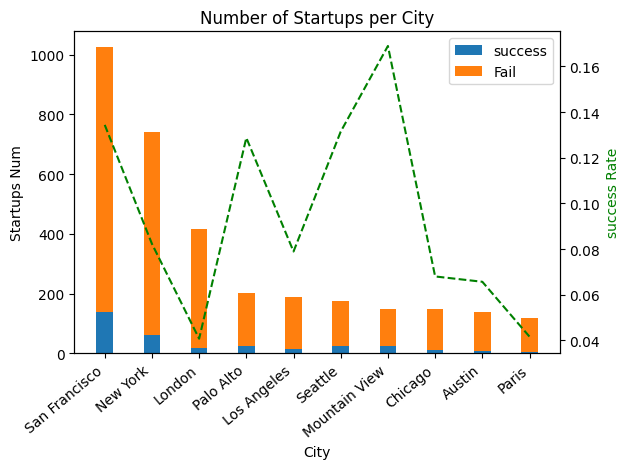

In [56]:
# 画图
labels = cities_startups.city
success_means = cities_startups.success
fail_means = cities_startups.fail
y2=cities_startups.success_per


width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.bar(labels,success_means, width, label='success')
ax.bar(labels, fail_means, width, bottom=success_means,
       label='Fail')
ax.set_xlabel('City')
ax.set_ylabel('Startups Num')


ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") # ha表示文字的哪个位置是对应坐标轴的位置参考

ax2.set_ylabel('success Rate', color='g')
ax2.plot(labels, y2, 'g--')
ax.set_title('Number of Startups per City')
ax.legend()
# fig.show()
fig.savefig('Number_of_Startups_per_City.png', dpi=1000, transparent=True)

## 画前15个行业分布的初创公司

In [57]:
# 数据处理
industry_startups = startups.groupby(['market']).agg({'name': 'nunique',
                                                    'success': "sum"}).sort_values(by="name",ascending=False)

industry_startups['fail'] = industry_startups['name'] - industry_startups['success']
industry_startups['success_per'] = industry_startups['success'] / industry_startups['name']

industry_startups=industry_startups.head(10)
industry_startups.reset_index(inplace=True)
industry_startups

,market,name,success,fail,success_per
0,web,2338,186,2152,0.0796
1,software,1783,87,1696,0.0488
2,mobile,967,69,898,0.0714
3,advertising,855,64,791,0.0749
4,games_video,796,63,733,0.0791
5,ecommerce,794,40,754,0.0504
6,enterprise,677,55,622,0.0812
7,other,634,19,615,0.0300
8,consulting,404,6,398,0.0149
9,public_relations,287,7,280,0.0244


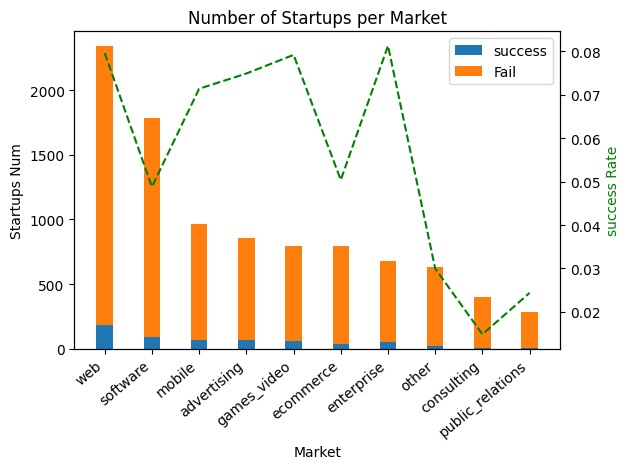

In [58]:
# 画图
labels = industry_startups.market
success_means = industry_startups.success
fail_means = industry_startups.fail
y2=industry_startups.success_per


width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.bar(labels,success_means, width, label='success')
ax.bar(labels, fail_means, width, bottom=success_means,
       label='Fail')
ax.set_xlabel('Market')
ax.set_ylabel('Startups Num')


ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") # ha表示文字的哪个位置是对应坐标轴的位置参考

ax2.set_ylabel('success Rate', color='g')
ax2.plot(labels, y2, 'g--')
ax.set_title('Number of Startups per Market')
ax.legend()
# fig.show()
fig.savefig('Number_of_Startups_per_Market.png', dpi=1000, transparent=True)

## 画教育信息的图

In [59]:
startups.head()

,id,name,market,status,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year,...,BS,MBA,MS,PhD,unknown,public_at,acquired_at,success,startup,age
0,c:1,Wetpaint,web,operating,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000,...,0.0000,0.0000,0.0000,0.0000,2.0000,nan,nan,0,1,8.0000
3,c:10002,Synergie Media,advertising,operating,MAR,Agadir,nan,0.0000,2.0000,2007.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,nan,nan,0,1,6.0000
4,c:1001,FriendFeed,web,acquired,USA,Mountain View,1.0000,5000000.0000,14.0000,2007.0000,...,1.0000,0.0000,1.0000,0.0000,0.0000,nan,2009.0000,1,1,6.0000
5,c:10011,PoetryVisualized.com,games_video,operating,USA,Julian,nan,0.0000,3.0000,2008.0000,...,0.0000,0.0000,0.0000,0.0000,2.0000,nan,nan,0,1,5.0000
6,c:10014,Mobclix,mobile,acquired,USA,Palo Alto,1.0000,0.0000,9.0000,2008.0000,...,0.0000,0.0000,1.0000,0.0000,4.0000,nan,2010.0000,1,1,5.0000


In [60]:
# 数据处理
edu_info = startups.groupby(['success']).agg({'BS': 'sum','BA': 'sum','MBA': 'sum','MS': 'sum','PhD': 'sum','unknown': 'sum'})

edu_info.reset_index(inplace=True)
edu_info

,success,BS,BA,MBA,MS,PhD,unknown
0,0,2471.0000,1544.0000,997.0000,900.0000,247.0000,12003.0000
1,1,253.0000,185.0000,112.0000,56.0000,24.0000,1017.0000


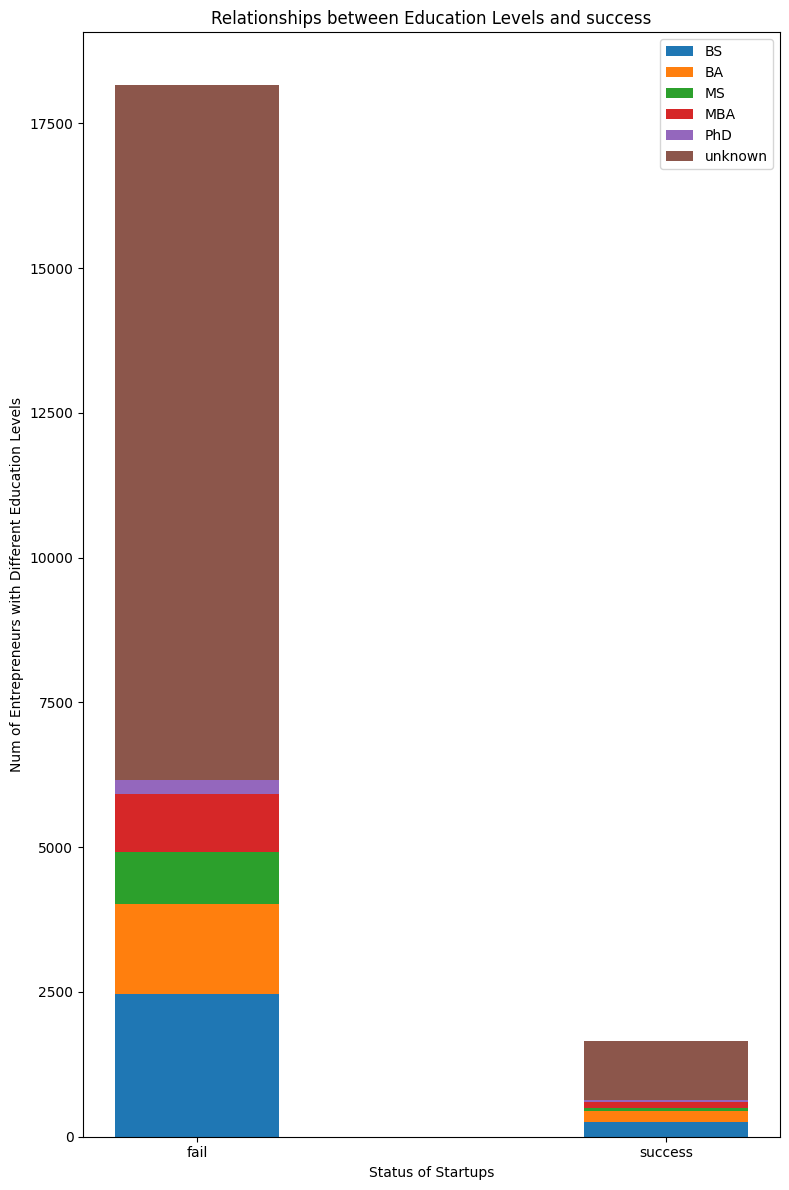

In [61]:
# 画图(有unknown)
labels = ['fail','success']
BS_means = edu_info.BS
BA_means = edu_info.BA
MS_means = edu_info.MS
MBA_means = edu_info.MBA
PhD_means = edu_info.PhD
unknown_means = edu_info.unknown


width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(8,12))

ax.bar(labels,BS_means, width, label='BS')
ax.bar(labels, BA_means, width, bottom=BS_means,label='BA')
ax.bar(labels, MS_means, width, bottom=BS_means+BA_means,label='MS')
ax.bar(labels, MBA_means, width, bottom=BS_means+BA_means+MS_means,label='MBA')
ax.bar(labels, PhD_means, width, bottom=BS_means+BA_means+MS_means+MBA_means,label='PhD')
ax.bar(labels, unknown_means, width, bottom=BS_means+BA_means+MS_means+MBA_means+PhD_means,label='unknown')


ax.set_xlabel('Status of Startups')
ax.set_ylabel('Num of Entrepreneurs with Different Education Levels')
ax.set_title('Relationships between Education Levels and success')
ax.legend()
# fig.show()
fig.savefig('Relationships_between_Education_Levels_and_success(with unknown).png', dpi=1000, transparent=True)

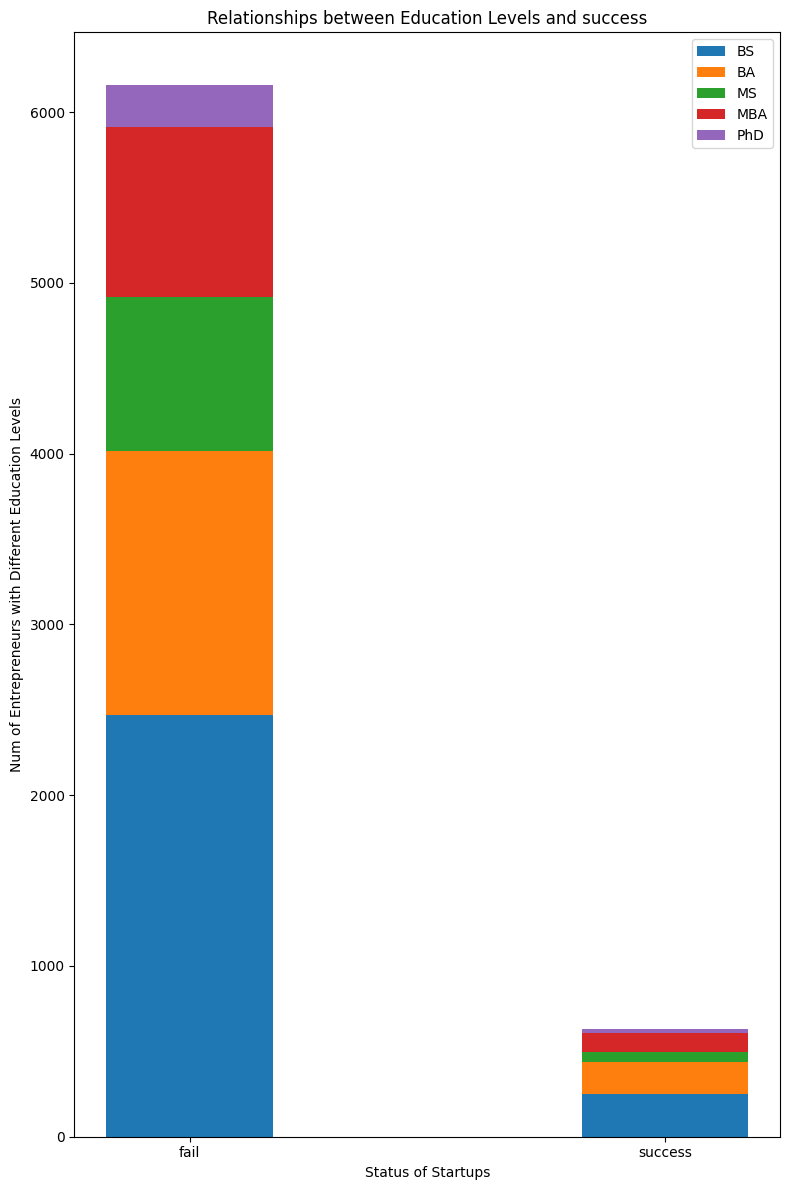

In [62]:
# 画图(无unknown)
labels = ['fail','success']
BS_means = edu_info.BS
BA_means = edu_info.BA
MS_means = edu_info.MS
MBA_means = edu_info.MBA
PhD_means = edu_info.PhD
unknown_means = edu_info.unknown


width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(8,12))

ax.bar(labels,BS_means, width, label='BS')
ax.bar(labels, BA_means, width, bottom=BS_means,label='BA')
ax.bar(labels, MS_means, width, bottom=BS_means+BA_means,label='MS')
ax.bar(labels, MBA_means, width, bottom=BS_means+BA_means+MS_means,label='MBA')
ax.bar(labels, PhD_means, width, bottom=BS_means+BA_means+MS_means+MBA_means,label='PhD')


ax.set_xlabel('Status of Startups')
ax.set_ylabel('Num of Entrepreneurs with Different Education Levels')


ax.set_title('Relationships between Education Levels and success')
ax.legend()
# fig.show()
fig.savefig('Relationships_between_Education_Levels_and_success(without unknown).png', dpi=1000, transparent=True)

## 画每年的初创公司密度分布

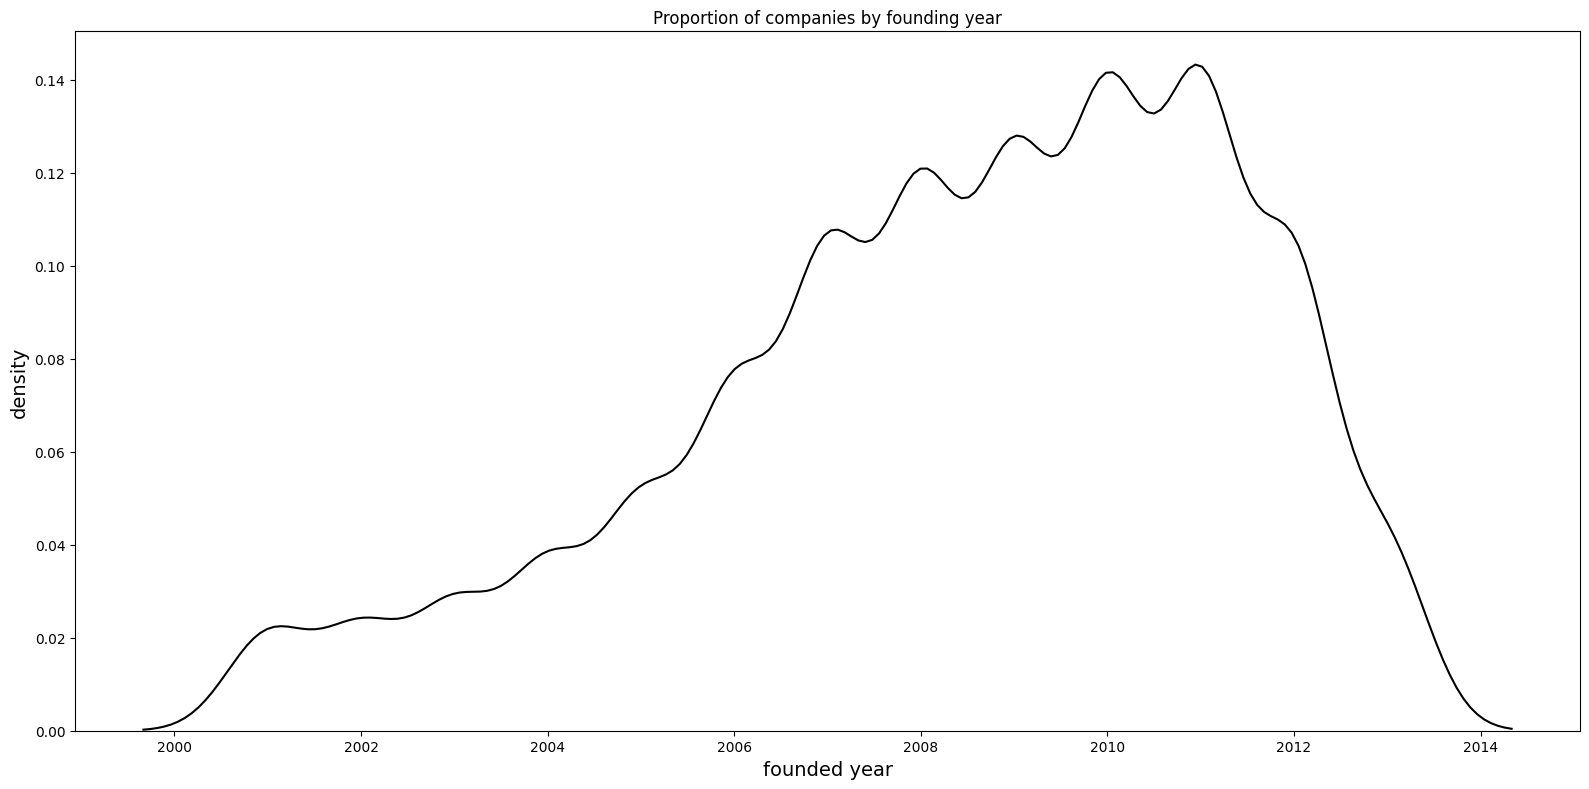

In [63]:
plt.figure(figsize=(16,8))
sns.kdeplot(startups['founded_year'], color="black", legend=False)
plt.xlabel('founded year',fontsize=14)
plt.ylabel('density',fontsize=14)
plt.tight_layout()
plt.title('Proportion of companies by founding year')
plt.savefig('year_of_founding.png', dpi=300, transparent=True)

# 为了正确选择特征处理数据

In [64]:
# 选一些参数参与训练，并且将含有缺失值的数据行删除，第二次数据锐减，这里可以调整
startups_new=startups.drop(['id','name','status','public_at','acquired_at'], axis=1)
startups_new=startups_new.dropna(axis=0,subset = ['market', 
                   'country_code',
                   'city',
                   'funding_rounds', 
                   'funding_total_usd',
                    'relationships',
                   'founded_year', 
                   'numEntrepreneurs',
                   'relationships'
                          ])

In [65]:
# 看一眼剩下的数据规模和成功企业比例
startups_new.success.value_counts()

0    4498
1     492
Name: success, dtype: int64

In [66]:
# 提取标签
st_status = startups_new[['success']]

In [67]:
# 提取特征
st_features = startups_new.drop('success',axis=1)

In [68]:
# 利用pandas的方法实现one hot encode
st_features = pd.get_dummies(st_features)

In [69]:
# 把label和特征合并在一起
st_master = pd.concat([st_status,st_features],axis=1)

In [70]:
# 初步设置训练集
# 后面的列是特征
X_log_success = st_master.drop('success',axis=1)
# 第一列是label
y_log_success = st_master['success']

In [71]:
# 特征提取，从我们手动添加的特征中提取5个相关程度最高的特征
selector_f = SelectKBest(f_regression, k='all')
selector_f.fit(X_log_success, y_log_success)

name_var = [X_log_success.columns]
var_score = selector_f.scores_

kbest = pd.DataFrame(var_score, name_var).sort_values(by=0, ascending=False).head(20).reset_index()
kbest.columns = ['var', 'score']

In [72]:
f_reg_var = kbest['var'].tolist()

In [73]:
# 前几个相关性高的特征
f_reg_var

['country_code_USA',
 'city_San Francisco',
 'market_web',
 'founded_year',
 'age',
 'numEntrepreneurs',
 'city_Cupertino',
 'unknown',
 'city_Mountain View',
 'city_Dulles',
 'city_San Bruno',
 'city_Menlo Park',
 'BS',
 'city_Rijswijk',
 'city_North Hollywood',
 'city_Motebelluna',
 'city_Ferndale',
 'city_Kitchener, ON',
 'city_Temecula',
 'city_South Pasadena']

# 根据相关性选用特征重新进行数据处理

In [74]:
startups_new.head()

,market,country_code,city,funding_rounds,funding_total_usd,relationships,founded_year,numEntrepreneurs,BA,BS,MBA,MS,PhD,unknown,success,startup,age
0,web,USA,Seattle,3.0000,39750000.0000,17.0000,2005.0000,2,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0,1,8.0000
4,web,USA,Mountain View,1.0000,5000000.0000,14.0000,2007.0000,2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1,1,6.0000
6,mobile,USA,Palo Alto,1.0000,0.0000,9.0000,2008.0000,5,0.0000,0.0000,0.0000,1.0000,0.0000,4.0000,1,1,5.0000
7,health,USA,San Francisco,5.0000,68069200.0000,14.0000,2007.0000,5,0.0000,1.0000,0.0000,1.0000,0.0000,3.0000,0,1,6.0000
9,analytics,USA,San Francisco,3.0000,33000000.0000,19.0000,2006.0000,4,1.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0,1,7.0000


In [75]:
startups_new=startups.drop(['id','name','status','public_at','acquired_at','funding_rounds','funding_total_usd','relationships'], axis=1)
startups_new=startups_new.dropna(axis=0,subset = ['market', 
                   'country_code',
                   'city',
                   'founded_year', 
                   'numEntrepreneurs',
                          ])

In [76]:
# 提取标签
st_status = startups_new[['success']]

In [77]:
# 提取特征
st_features = startups_new.drop('success',axis=1)

In [78]:
# 利用pandas的方法实现one hot encode
st_features = pd.get_dummies(st_features)

In [79]:
# 把label和特征合并在一起
st_master = pd.concat([st_status,st_features],axis=1)

In [80]:
# 数据均衡，调整正反例数据比例，对多的数据进行下采样，用于避免机器学习时产生误差

# 区分哪个标签的数量多
if st_master.success.mean()<0.5:
    success_majority = st_master[st_master.success==0]
    success_minority = st_master[st_master.success==1]
else:
    success_majority = st_master[st_master.success==1]
    success_minority = st_master[st_master.success==0]
    
# 对数量多的标签数据进行下采样
success_majority_downsampled = resample(success_majority, 
                                 replace=False,    # 采样后不替换原数据
                                 n_samples=success_minority.success.count(),
                                 random_state=123) # 固定随机种子确保每次运行实验结果都相同
 
# 把降采样后的标签与小规模标签数据融合
success_downsampled = pd.concat([success_majority_downsampled, success_minority])

In [81]:
# 看一眼最终的数据集大小
success_downsampled.success.value_counts()

1    648
0    648
Name: success, dtype: int64

In [82]:
# 初步设置训练集
# 后面的列是特征
X_log_success = success_downsampled.drop('success',axis=1)
# 第一列是label
y_log_success = success_downsampled['success']

In [83]:
# 特征提取，从我们手动添加的特征中提取5个相关程度最高的特征
selector_f = SelectKBest(f_regression, k='all')
selector_f.fit(X_log_success, y_log_success)

name_var = [X_log_success.columns]
var_score = selector_f.scores_

kbest = pd.DataFrame(var_score, name_var).sort_values(by=0, ascending=False).head(20).reset_index()
kbest.columns = ['var', 'score']

In [84]:
f_reg_var = kbest['var'].tolist()

In [85]:
# # 最终采用的特征
f_reg_var

['country_code_USA',
 'city_San Francisco',
 'numEntrepreneurs',
 'BS',
 'unknown',
 'age',
 'founded_year',
 'market_consulting',
 'market_biotech',
 'BA',
 'market_mobile',
 'market_public_relations',
 'country_code_AUS',
 'market_cleantech',
 'country_code_IND',
 'city_San Mateo',
 'MBA',
 'market_real_estate',
 'city_Mountain View',
 'country_code_GBR']

# 训练用数据集准备

In [86]:
success_log = sm.Logit(success_downsampled['success'], success_downsampled[f_reg_var]).fit()
print(success_log.summary())

         Current function value: 0.616150
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                 1296
Model:                          Logit   Df Residuals:                     1276
Method:                           MLE   Df Model:                           19
Date:                Sun, 23 May 2021   Pseudo R-squ.:                  0.1111
Time:                        22:11:55   Log-Likelihood:                -798.53
converged:                      False   LL-Null:                       -898.32
Covariance Type:            nonrobust   LLR p-value:                 4.135e-32
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
country_code_USA            0.5017      0.157      3.202      0.001       0.195       0.809
city_San Francisco        

l:\anaconda3\envs\cs277\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [87]:
master_success = sklearn.utils.resample(success_downsampled, random_state=3) #  此处的随机数对结果影响较大

# 重新确定训练特征和label
X_success = master_success[f_reg_var]

y_success = master_success['success']

# 分训练集和测试集
X_success_train, X_success_test, y_success_train, y_success_test = train_test_split(X_success, 
                                                                                        y_success,
                                                                                        test_size=0.3,
                                                                                        random_state=5)

print(X_success_train.shape, y_success_train.shape)
print(X_success_test.shape, y_success_test.shape)

(907, 20) (907,)
(389, 20) (389,)


# 训练模型

In [88]:
# 逻辑回归训练
logit = LogisticRegression()
model_logit = logit.fit(X_success_train, y_success_train)

In [89]:
#随机森林
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state = 42)
model_rf = rf.fit(X_success_train, y_success_train)

In [90]:
#SVM
from sklearn import svm
model_svm = svm.SVC(C=2, kernel='linear', gamma=8)
model_svm = model_svm.fit(X_success_train, y_success_train)

In [91]:
#XGBoost
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()
model_xgb = xgb_classifier.fit(X_success_train, y_success_train)

[22:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# 进行预测

In [92]:
# 逻辑回归预测
prediction_logit = model_logit.predict(X_success_test)
print("Score:", model_logit.score(X_success_test, y_success_test))

Score: 0.6786632390745502


In [93]:
#随机森林预测
predictions_rf = model_rf.predict(X_success_test)
print("Score:", model_rf.score(X_success_test, y_success_test))

Score: 0.7557840616966581


In [94]:
#SVM预测
predictions_svm = model_svm.predict(X_success_test)
print("Score:", model_svm.score(X_success_test, y_success_test))

Score: 0.6580976863753213


In [95]:
#XGBoost 预测
predictions_xgb = model_xgb.predict(X_success_test)
print("Score:", model_xgb.score(X_success_test, y_success_test))

Score: 0.7223650385604113


# 使用指标衡量预测结果好坏

In [96]:
# 其他衡量指标
kfold = model_selection.KFold(n_splits=10, random_state=5)
results_logit_acc = model_selection.cross_val_score(logit, X_success_train, y_success_train, cv=kfold, scoring='accuracy')
results_logit_pre = model_selection.cross_val_score(logit, X_success_train, y_success_train, cv=kfold, scoring='precision')
results_logit_rec = model_selection.cross_val_score(logit, X_success_train, y_success_train, cv=kfold, scoring='recall')

print("10-fold cross validation average accuracy: %.3f" % (results_logit_acc.mean()))
print("10-fold cross validation average precision: %.3f" % (results_logit_pre.mean()))
print("10-fold cross validation average recall: %.3f" % (results_logit_rec.mean()))

10-fold cross validation average accuracy: 0.640
10-fold cross validation average precision: 0.644
10-fold cross validation average recall: 0.568


# 画混淆矩阵

In [97]:
#绘制混淆矩阵函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.80829016 0.19170984]
 [0.44897959 0.55102041]]


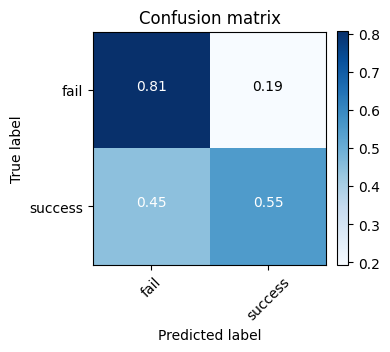

In [108]:
# 逻辑回归混淆矩阵
confusion_matrix_log = confusion_matrix(y_success_test, prediction_logit)
class_names=["fail","success"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(confusion_matrix_log, classes=class_names, normalize=True)
plt.savefig('confusion_matrix_logistic_regression.png', dpi=300, transparent=True)
plt.show()

Normalized confusion matrix
[[0.74611399 0.25388601]
 [0.23469388 0.76530612]]


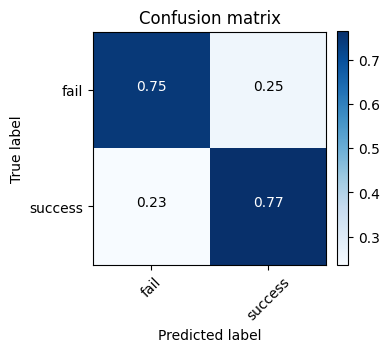

In [109]:
# 随机森林混淆矩阵
confusion_matrix_log_rf = confusion_matrix(y_success_test, predictions_rf)
class_names_rf=["fail","success"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(confusion_matrix_log_rf, classes=class_names_rf, normalize=True)
plt.savefig('confusion_matrix_rf.png', dpi=300, transparent=True)
plt.show()

Normalized confusion matrix
[[0.48186528 0.51813472]
 [0.16836735 0.83163265]]


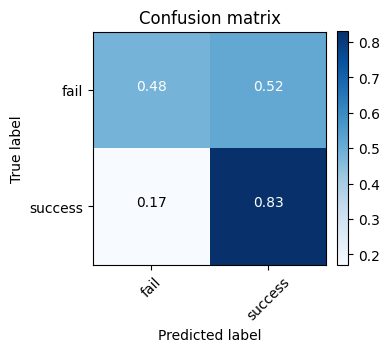

In [110]:
# SVM混淆矩阵
confusion_matrix_log_svm = confusion_matrix(y_success_test, predictions_svm)
class_names_svm=["fail","success"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(confusion_matrix_log_svm, classes=class_names_svm, normalize=True)
plt.savefig('confusion_matrix_svm.png', dpi=300, transparent=True)
plt.show()

Normalized confusion matrix
[[0.70466321 0.29533679]
 [0.26020408 0.73979592]]


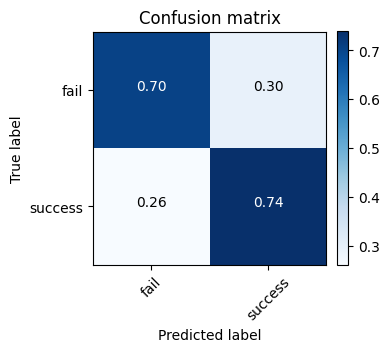

In [111]:
# XGBoost混淆矩阵
confusion_matrix_log_xgb = confusion_matrix(y_success_test, predictions_xgb)
class_names_xgb=["fail","success"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(4,4))
plot_confusion_matrix(confusion_matrix_log_xgb, classes=class_names_xgb, normalize=True)
plt.savefig('confusion_matrix_xgb.png', dpi=300, transparent=True)
plt.show()